In [4]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [5]:
# Read data into pandas
japan = pd.read_excel(".././data/Price History_EWJ_Japan_Equity.xlsx")
t_bills_7_10 = pd.read_excel(".././data/Price History_7-10_US_TBills.xlsx")
t_bills_20 = pd.read_excel(".././data/Price History_20+_US_TBills.xlsx")
apac_x_japan = pd.read_excel(".././data/Price History_EPP_APACxJapan_Equity.xlsx")
europe = pd.read_excel(".././data/Price History_IEV_Europe_Equity.xlsx")
latam = pd.read_excel(".././data/Price History_ILF_LatAm_Equity.xlsx")
us = pd.read_excel(".././data/Price History_IVV_US_Equity.xlsx")
gold = pd.read_excel(".././data/Price History_IAU_Gold_Trust.xlsx")

In [6]:
def preprocess_and_rename(df, name):
    df['Exchange Date'] = pd.to_datetime(df['Exchange Date'])
    df.set_index('Exchange Date', inplace=True)
    df.rename(columns={'%Chg':f'Return {name}'}, inplace=True)
    return df[[f'Return {name}']]

# Preprocess all datasets and rename columns
japan = preprocess_and_rename(japan, 'Japan')
t_bills_7_10 = preprocess_and_rename(t_bills_7_10, 'T-Bills_7_10')
t_bills_20 = preprocess_and_rename(t_bills_20, 'T-Bills_20')
apac_x_japan = preprocess_and_rename(apac_x_japan, 'APACxJapan')
europe = preprocess_and_rename(europe, 'Europe')
latam = preprocess_and_rename(latam, 'LatAm')
us = preprocess_and_rename(us, 'US')
gold = preprocess_and_rename(gold, 'Gold')

In [7]:
us

,Return US
Exchange Date,
2024-12-13,-0.000181
2024-12-12,-0.005306
2024-12-11,0.007707
2024-12-10,-0.002896
2024-12-09,-0.005157
...,...
2005-01-07,-0.001852
2005-01-06,0.004058
2005-01-05,-0.006050


In [8]:
# Merge all datasets on 'Exchange Date'
returns = japan.join([t_bills_7_10, t_bills_20, apac_x_japan, europe, latam, us, gold], how='inner')

# Rename the columns for clarity
returns.columns = ['Japan', 'T-Bills_7_10', 'T-Bills_20', 
                'APACxJapan','Europe','LatAm', 'US', 'Gold']
returns = returns.dropna()
returns = returns.sort_values(by='Exchange Date', ascending=True)

In [9]:
start_date = '2008-10-31'
end_date = '2011-01-31'
returns = returns[start_date:end_date]
returns

,Japan,T-Bills_7_10,T-Bills_20,APACxJapan,Europe,LatAm,US,Gold
Exchange Date,,,,,,,,
2008-10-31,-0.050088,-0.002939,-0.013435,-0.017445,0.013728,-0.012695,0.017978,-0.014050
2008-11-03,-0.006176,0.004900,0.006745,0.068494,0.010404,0.017910,-0.004005,-0.004610
2008-11-04,0.044846,0.010505,0.016052,0.015052,0.062001,0.095253,0.037629,0.061754
2008-11-05,0.066193,0.003580,0.008355,0.032862,-0.015571,-0.106184,-0.047591,-0.035030
2008-11-06,-0.050984,-0.001188,-0.004694,-0.061711,-0.074999,-0.057462,-0.051742,-0.006986
...,...,...,...,...,...,...,...,...
2011-01-25,0.014322,0.006701,0.014149,0.000046,-0.007334,-0.008805,-0.000154,-0.001533
2011-01-26,-0.006244,-0.007169,-0.019952,0.003369,0.009656,0.005223,0.004784,0.008250
2011-01-27,0.000442,0.003607,0.006388,-0.000943,0.004141,-0.011191,0.002381,-0.024167


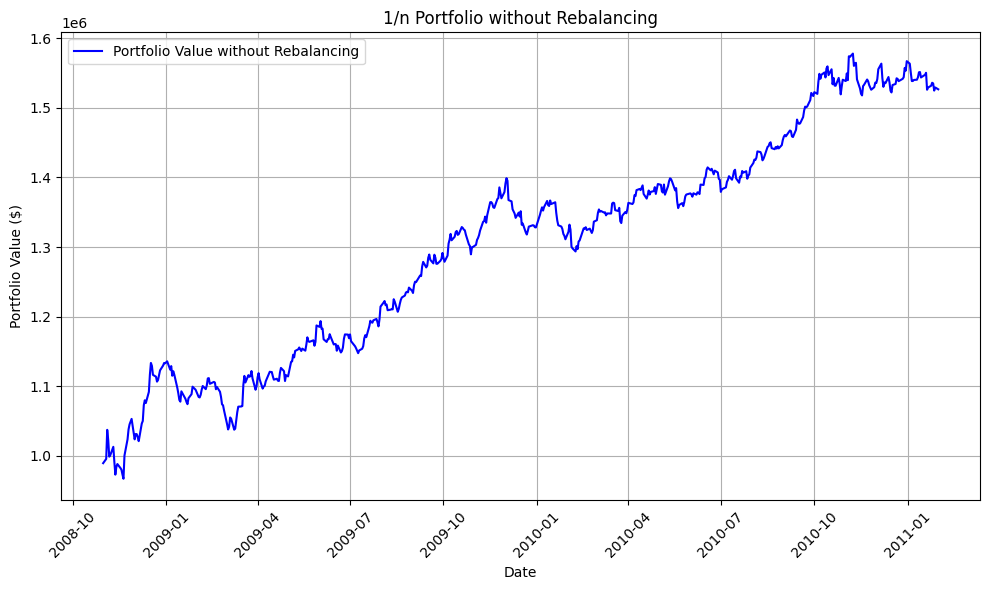

Final Portfolio Value (Non-Rebalancing): $1,526,715.37


In [10]:
#### 1/n Non-Rebalancing Portfolio Construction #### ver 2.0

weights = {
    'Japan': 1/15,
    'T-Bills_7_10': 1/6,
    'T-Bills_20': 1/6,
    'APACxJapan': 1/15,
    'Europe': 1/15,
    'LatAm': 1/15,
    'US': 1/15,
    'Gold': 1/3,
}

# Convert weights to a Series for alignment
weights_series = pd.Series(weights)

# Calculate daily portfolio returns
portfolio_return = (returns[weights_series.index] * weights_series).sum(axis=1)

# Calculate cumulative return
cumulative_return = (1 + portfolio_return).cumprod() - 1

# Initial investment
initial_investment_non_rebalancing = 1_000_000  # $1 million

# Calculate portfolio value over time (non-rebalanced)
portfolio_value_non_rebalancing = initial_investment_non_rebalancing * (1 + cumulative_return)

# Plot the portfolio value
plt.figure(figsize=(10, 6))
plt.plot(portfolio_value_non_rebalancing, label='Portfolio Value without Rebalancing', color='blue')
plt.title('1/n Portfolio without Rebalancing')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print final portfolio value
print(f"Final Portfolio Value (Non-Rebalancing): ${portfolio_value_non_rebalancing.iloc[-1]:,.2f}")


In [11]:
#### 1/n Non-Rebalancing Portfolio Analytics #### ver 2.0

# 1) Resample to monthly frequency and calculate monthly returns
monthly_portfolio_value_nonrebal = portfolio_value_non_rebalancing.resample('ME').ffill()
monthly_returns_nonrebal = monthly_portfolio_value_nonrebal.pct_change().dropna()

# 2) Full-sample monthly volatility, then annualize
full_sample_monthly_vol_nonrebal = monthly_returns_nonrebal.std()
annualized_vol_nonrebal = full_sample_monthly_vol_nonrebal * np.sqrt(12)

# 3) Total return & Geometric means
initial_val_nonrebal = portfolio_value_non_rebalancing.iloc[0]
final_val_nonrebal = portfolio_value_non_rebalancing.iloc[-1]
total_return_nonrebal = (final_val_nonrebal - initial_val_nonrebal) / initial_val_nonrebal

n_months_nonrebal = len(monthly_returns_nonrebal)
geo_avg_monthly_return_nonrebal = (final_val_nonrebal / initial_val_nonrebal) ** (1 / n_months_nonrebal) - 1
geo_avg_yearly_return_nonrebal = (1 + geo_avg_monthly_return_nonrebal) ** 12 - 1

# 4) Sharpe Ratio
arithmetic_monthly_return_nonrebal = monthly_returns_nonrebal.mean()
annualized_arithmetic_return_nonrebal = arithmetic_monthly_return_nonrebal * 12
sharpe_ratio_nonrebal = annualized_arithmetic_return_nonrebal / annualized_vol_nonrebal

# 5) Monthly 99% VaR
VaR_99_nonrebal = monthly_returns_nonrebal.quantile(1 - 0.99)

# 6) Print results
print("### 1/n Non-Rebalancing Portfolio Analytics ###")
print(f"Full-sample annualized monthly volatility: {annualized_vol_nonrebal:.4f}")
print(f"Total return: {total_return_nonrebal * 100:.2f}%")
print(f"Geometric avg monthly return (CAGR basis): {geo_avg_monthly_return_nonrebal * 100:.2f}%")
print(f"Geometric avg yearly return (CAGR basis): {geo_avg_yearly_return_nonrebal * 100:.2f}%")
print(f"Sharpe Ratio (Arithmetic Return / Annualized Vol): {sharpe_ratio_nonrebal:.2f}")
print(f"Monthly 99% Value at Risk (VaR): {VaR_99_nonrebal:.4f}")


### 1/n Non-Rebalancing Portfolio Analytics ###
Full-sample annualized monthly volatility: 0.1070
Total return: 54.31%
Geometric avg monthly return (CAGR basis): 1.62%
Geometric avg yearly return (CAGR basis): 21.27%
Sharpe Ratio (Arithmetic Return / Annualized Vol): 1.87
Monthly 99% Value at Risk (VaR): -0.0360


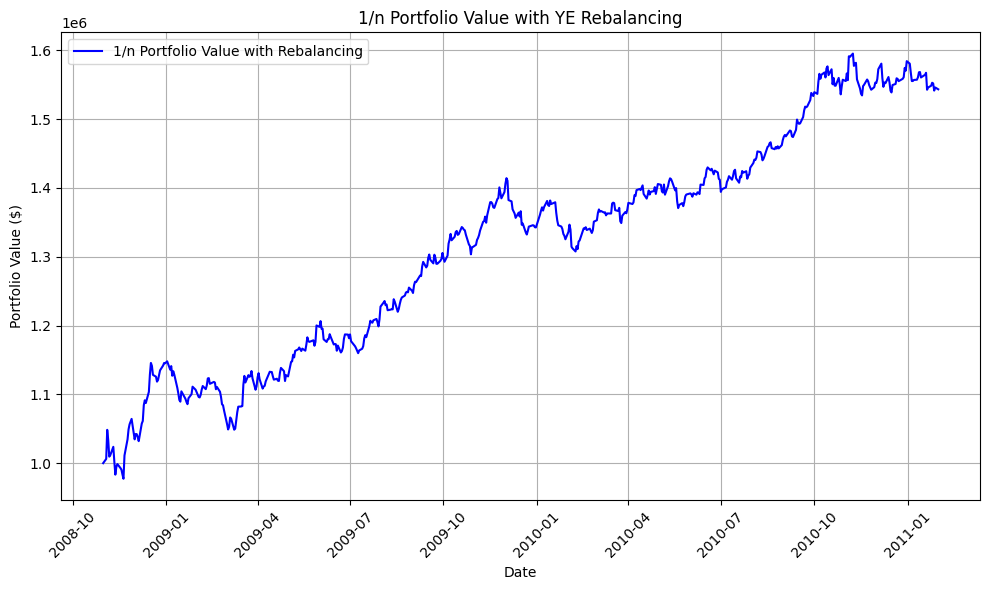

Final Portfolio Value (Rebalancing): $1,543,145.03


In [12]:
#### 1/n Rebalancing Portfolio Construction #### ver 2.0

# Define rebalancing frequency
n_frequency_rebalancing = 'YE'  # 'ME' = monthly, 'QE' = quarterly, 'YE' = yearly

# Define asset-class weights
asset_class_weights_rebalancing = {
    'equities': 1/3,
    'bonds': 1/3,
    'gold': 1/3,
}

# Equity and bond sub-weights
equity_weights_rebalancing = {
    'Japan': 1/15,
    'APACxJapan': 1/15,
    'Europe': 1/15,
    'LatAm': 1/15,
    'US': 1/15,
}
bond_weights_rebalancing = {
    'T-Bills_7_10': 1/6,
    'T-Bills_20': 1/6,
}

# Determine rebalancing dates
rebal_dates_rebalancing = returns.resample(n_frequency_rebalancing).last().index
aligned_rebal_dates = returns.index.get_indexer(rebal_dates_rebalancing, method='nearest')
rebal_dates_rebalancing = returns.index[aligned_rebal_dates]

# Initialize daily portfolio value
initial_investment_rebalancing = 1_000_000
portfolio_value_rebalancing = pd.Series(index=returns.index, dtype=float)
portfolio_value_rebalancing.iloc[0] = initial_investment_rebalancing

# Initialize weights
current_weights = pd.Series(0.0, index=returns.columns)
current_weights.update(pd.Series(equity_weights_rebalancing))
current_weights.update(pd.Series(bond_weights_rebalancing))
current_weights['Gold'] = asset_class_weights_rebalancing['gold']

# Define transaction cost rate (0.1% of turnover)
transaction_cost_rate = 0.001

# Portfolio rebalancing loop
for i in range(len(rebal_dates_rebalancing)):
    this_rebal_date = rebal_dates_rebalancing[i]

    # Update weights on rebalancing dates
    if i == 0:
        prev_rebal_date = portfolio_value_rebalancing.index[0]
    else:
        prev_rebal_date = rebal_dates_rebalancing[i - 1]

    daily_index_slice = portfolio_value_rebalancing.index[
        (portfolio_value_rebalancing.index >= prev_rebal_date) &
        (portfolio_value_rebalancing.index <= this_rebal_date)
    ]

    for d in range(1, len(daily_index_slice)):
        today = daily_index_slice[d]
        yesterday = daily_index_slice[d - 1]
        daily_return = (returns.loc[today] * current_weights).sum()
        portfolio_value_rebalancing.loc[today] = portfolio_value_rebalancing.loc[yesterday] * (1 + daily_return)

    # Rebalance weights at the end of this period
    if i < len(rebal_dates_rebalancing) - 1:
        current_weights.update(pd.Series(equity_weights_rebalancing))
        current_weights.update(pd.Series(bond_weights_rebalancing))
        current_weights['Gold'] = asset_class_weights_rebalancing['gold']

# Ensure the portfolio value has daily entries
portfolio_value_rebalancing.ffill(inplace=True)

# Plot the portfolio value
plt.figure(figsize=(10, 6))
plt.plot(portfolio_value_rebalancing, label='1/n Portfolio Value with Rebalancing', color='blue')
plt.title(f'1/n Portfolio Value with {n_frequency_rebalancing} Rebalancing')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print final portfolio value
print(f"Final Portfolio Value (Rebalancing): ${portfolio_value_rebalancing.iloc[-1]:,.2f}")


In [13]:
#### 1/n Rebalancing Portfolio Analytics #### ver 2.0

# 1) Resample to monthly frequency and calculate monthly returns
monthly_portfolio_value_rebalancing = portfolio_value_rebalancing.resample('ME').ffill()
monthly_returns_rebalancing = monthly_portfolio_value_rebalancing.pct_change().dropna()

# 2) Full-sample monthly volatility, then annualize
full_sample_monthly_vol_rebalancing = monthly_returns_rebalancing.std()
annualized_vol_rebalancing = full_sample_monthly_vol_rebalancing * np.sqrt(12)

# 3) Total return & Geometric means
initial_val_rebalancing = portfolio_value_rebalancing.iloc[0]
final_val_rebalancing = portfolio_value_rebalancing.iloc[-1]
total_return_rebalancing = (final_val_rebalancing - initial_val_rebalancing) / initial_val_rebalancing

n_months_rebalancing = len(monthly_returns_rebalancing)
geo_avg_monthly_return_rebalancing = (final_val_rebalancing / initial_val_rebalancing) ** (1 / n_months_rebalancing) - 1
geo_avg_yearly_return_rebalancing = (1 + geo_avg_monthly_return_rebalancing) ** 12 - 1

# 4) Sharpe Ratio
arithmetic_monthly_return_rebalancing = monthly_returns_rebalancing.mean()
annualized_arithmetic_return_rebalancing = arithmetic_monthly_return_rebalancing * 12
sharpe_ratio_rebalancing = annualized_arithmetic_return_rebalancing / annualized_vol_rebalancing

# 5) Monthly 99% VaR
VaR_99_rebalancing = monthly_returns_rebalancing.quantile(1 - 0.99)

# 6) Print results
print("### 1/n Rebalancing Portfolio Analytics ###")
print(f"Full-sample annualized monthly volatility: {annualized_vol_rebalancing:.4f}")
print(f"Total return: {total_return_rebalancing * 100:.2f}%")
print(f"Geometric avg monthly return (CAGR basis): {geo_avg_monthly_return_rebalancing * 100:.2f}%")
print(f"Geometric avg yearly return (CAGR basis): {geo_avg_yearly_return_rebalancing * 100:.2f}%")
print(f"Sharpe Ratio (Arithmetic Return / Annualized Vol): {sharpe_ratio_rebalancing:.2f}")
print(f"Monthly 99% Value at Risk (VaR): {VaR_99_rebalancing:.4f}")


### 1/n Rebalancing Portfolio Analytics ###
Full-sample annualized monthly volatility: 0.1070
Total return: 54.31%
Geometric avg monthly return (CAGR basis): 1.62%
Geometric avg yearly return (CAGR basis): 21.27%
Sharpe Ratio (Arithmetic Return / Annualized Vol): 1.87
Monthly 99% Value at Risk (VaR): -0.0360
